<a href="https://colab.research.google.com/github/yenlung/Deep-Learning-Basics/blob/master/colab08b%20DeepFace%20%E9%80%B2%E9%9A%8E%E8%88%87%20Gradio%20%E7%9A%84%E9%85%8D%E5%90%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

還記得一般我們做圖形辨識, 都需要做一些預處理嗎? 那 DeepFace 難道有沒有辦法做預處理讓成效變得更好呢? 答案是肯定的。我們甚至可以把 DeepFace 用到的 model 讀進來!

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. 安裝並導入 DeepFace 及 Gradio

In [2]:
!pip install deepface

     |████████████████████████████████| 61 kB 5.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3 MB 37.7 MB/s 
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9046 sha256=b8f95be8671efdc92b21db16a6edcea0d2fdf5dc2d560bfec17706c31f2ab5ee
  Stored in directory: /root/.cache/pip/wheels/2f/2a/2f/86449b6bdbaa9aef873f68332b68be6bfbc386b9219f47157d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [3]:
!pip install gradio

     |████████████████████████████████| 2.2 MB 12.9 MB/s 
     |████████████████████████████████| 206 kB 58.9 MB/s 
     |████████████████████████████████| 1.9 MB 63.5 MB/s 
     |████████████████████████████████| 63 kB 3.4 MB/s 
     |████████████████████████████████| 961 kB 53.7 MB/s 
     |████████████████████████████████| 3.2 MB 41.5 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4709 sha256=b5cf455700cbf0ea4306e95fecbb5793102afaa26ea45e9c9fb5eec5aee9ae4c
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3372 sha256=ba5ab6425108e7afd334cb1f9eb309025707553d06e468d801c22025d69dc744
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


注意我們 DeepFace 多引入個叫 `functions` 的, 是準備做照片預處理之用的。

In [4]:
import cv2
from deepface import DeepFace
from deepface.commons import functions
import gradio as gr

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


### 2. 讀入範例照片集

和上次一樣。

In [5]:
!wget --no-check-certificate \
    https://github.com/yenlung/Deep-Learning-Basics/raw/master/images/photos.zip \
    -O /content/photos.zip

--2021-08-12 04:38:31--  https://github.com/yenlung/Deep-Learning-Basics/raw/master/images/photos.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yenlung/Deep-Learning-Basics/master/images/photos.zip [following]
--2021-08-12 04:38:31--  https://raw.githubusercontent.com/yenlung/Deep-Learning-Basics/master/images/photos.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1758026 (1.7M) [application/zip]
Saving to: ‘/content/photos.zip’

/content/photos.zip 100%[===================>]   1.68M  --.-KB/s    in 0.02s   

2021-08-12 04:38:31 (75.0 MB/s) - ‘/content/photos.zip’ saved [1758026/175802

In [6]:
import os
import zipfile

local_zip = '/content/photos.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

秀照片用的小函式一起來。

In [7]:
def show_image(*args):
    k = len(args)
    fig = plt.figure(figsize=(5*k, 5))
    for i, photo in enumerate(args):
        plt.subplot(1,k,i+1)
        plt.axis('off')
        plt.axis('equal')
        plt.imshow(cv2.cvtColor(photo, cv2.COLOR_BGR2RGB))

### 3. 做照片的預處理

照片可以這樣做預處理。

In [8]:
base_dir = "/content/photos"
face_dir = "/content/photos/faces"

In [9]:
labels = {'angry':'生氣', 'disgust':'厭惡', 'fear':'恐懼',
          'happy':'開心', 'neutral':'沒什麼特別表情', 
          'sad':'悲傷', 'surprise':'吃驚',
          'Man':'男', 'Woman':'女',
          'asian':'亞洲', 'black':'黑', 'indian':'印弟安',
          'latino hispanic':'拉丁美洲 (西班牙裔)', 
          'middle eastern':'中東', 'white':'白'}

In [10]:
def show_info(obj):
    age = obj['age']
    emotion = labels[obj['dominant_emotion']]
    race = labels[obj['dominant_race']]
    gender = labels[obj['gender']]
    if gender == '女':
        spam = '她'
    else:
        spam = '他'
    text = f"這是一位 {age} 歲的{race}人{gender}子, {spam}感覺是{emotion}的。"
    print(text)

第一個犠牲者, 我是說, 第一個測試。

In [11]:
im01_path = base_dir + '/' + "mengjie.jpg"
im01 = cv2.imread(im01_path)

In [12]:
obj = DeepFace.analyze(img_path = im01_path, actions = ['age', 'gender', 'race', 'emotion'])

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:01<00:00, 5.72MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [00:12<00:00, 44.6MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:12<00:00, 44.2MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [00:12<00:00, 42.8MB/s]
Action: emotion: 100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


這是一位 26 歲的亞洲人女子, 她感覺是開心的。


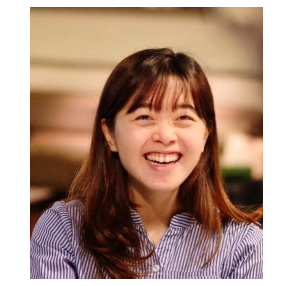

In [13]:
show_image(im01)
show_info(obj)

In [14]:
im01p = functions.preprocess_face(im01_path,
                                  detector_backend="mtcnn",
                                  )

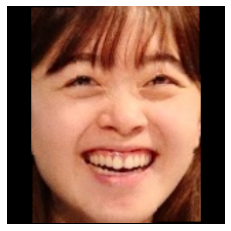

In [15]:
plt.axis('off')
plt.imshow(im01p[0][:,:,::-1])

我們發現就是把臉的部份切出來! 注意這時照片的 `shape` 是 (1, 224, 224, 3), 所以要把照片拿出來是用 `im01p[0]`。

4. 照片直接送給 `gradio` 並且用 webcam!

平常如果從 `gradio` 輸入一張照片, 即使是一個照片檔, `gradio` 都會好心的幫我們轉成 `numpy array`。但我們就是想要讓 `gradio` 不要動, 直接接受照片檔可以嗎? 答案是肯定的, 那就要在 `inputs` 時設好 `type`。

```python
inputs = gr.inputs.Image(type="file")
```

那我們的照片要用 webcam 輸入呢? 那也很容易, 就指定 `source="webcam"` 就可以了!


```python
inputs = gr.inputs.Image(source="webcam")
```


In [16]:
def webapp(img):
    obj = DeepFace.analyze(img_path=img.name, 
                           actions = ['age', 'gender', 'race', 'emotion'],
                           )
    age = obj['age']

    emotion = labels[obj['dominant_emotion']]
    race = labels[obj['dominant_race']]
    gender = labels[obj['gender']]
    if gender == '女':
        spam = '她'
    else:
        spam = '他'
    text = f"這是一位 {age} 歲的{race}人{gender}子, {spam}感覺是{emotion}的。"
    return text

注意我們 `image` 的 `type` 設為 `file`, 意思是我們可以直接把照片讀進來, 「檔案」的名稱在 `img.name` 裡面。

In [ ]:
inputs = gr.inputs.Image(label="來張自拍", source="webcam", type="file")
outputs = gr.outputs.Textbox(label="AI 辨識結果")


iface = gr.Interface(fn=webapp,
                     inputs=inputs,
                     outputs=outputs,
                     title="AI 辨識器",
                     description="點一下自拍, 讓我來猜猜你的年紀、種族、性別還有現在的情緒是什麼。")
iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Your interface requires microphone or webcam permissions - this may cause issues in Colab. Use the External URL in case of issues.
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://58897.gradio.app
Interface loading below...


Action: emotion: 100%|██████████| 4/4 [00:00<00:00, 10.75it/s]


### 5. 整個 `model` 都可以讀進來!

In [ ]:
model = DeepFace.build_model("Age")

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0     

In [ ]:
im01_path = base_dir + '/' + "mengjie.jpg"
im01p = functions.preprocess_face(im01_path,
              detector_backend="mtcnn",
              )

In [ ]:
age = np.argmax(model.predict(im01p).flatten())

In [ ]:
age

25

In [ ]:
im02_path = base_dir + '/mengchun.jpg'

In [ ]:
def show_age(img):
    im = functions.preprocess_face(img, detector_backend="mtcnn")
    age = np.argmax(model.predict(im)[0])
    plt.imshow(im[0][:,:,::-1])
    print(f"我覺得這個人是 {age} 歲。")

我覺得這個人是 25 歲。


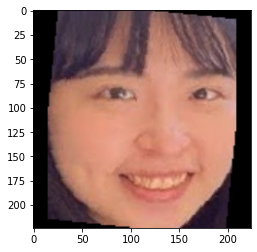

In [ ]:
show_age(im02_path)